<a href="https://colab.research.google.com/github/thekaitran/BA775-FallProject-KT/blob/main/Kai_Tran_ProjectM2_Q1_BA820_Team_4_Childcare_Costs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Childcare Costs Dataset**


---



# **1.1 Executive Summary**

Childcare isn't just a family issue; it’s a major economic factor. In the U.S., childcare is often one of the biggest expenses for a household, sometimes costing between 8.9% and 16% of a family's income, in many places, that is more than rent!

Research shows that when prices go up, parents (especially mothers) are often forced to leave the workforce. This project looks beyond just "average prices" to understand the diverse childcare markets across the U.S. We want to understand how costs relate to income, employment, and local economies so policymakers and employers can make better decisions.

In [22]:
from google.colab import drive
drive.mount('/content/drive')
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

!pip -q install umap-learn
import umap

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **1.2 Data Source**

We are using the National Database of Childcare Prices (NDCP), which covers U.S. county-level data from 2008–2018. The dataset includes:

Price Data: Weekly costs broken down by provider type (Center-based vs. Family-based) and age (Infant, Toddler, Preschool).

Socioeconomic Data: Census information including median income, poverty rates, unemployment, and labor force participation.

In [24]:
childcare = pd.read_csv("/content/drive/MyDrive/Boston University/Master/Spring26/BA820/childcare_costs.csv")
counties  = pd.read_csv("/content/drive/MyDrive/Boston University/Master/Spring26/BA820/counties.csv")

print("childcare shape:", childcare.shape)
print("counties shape:", counties.shape)

df = childcare.merge(counties, on="county_fips_code", how="left")

childcare shape: (34567, 61)
counties shape: (3144, 4)


# **1.3 Preliminary Exploratory Data Analysis**

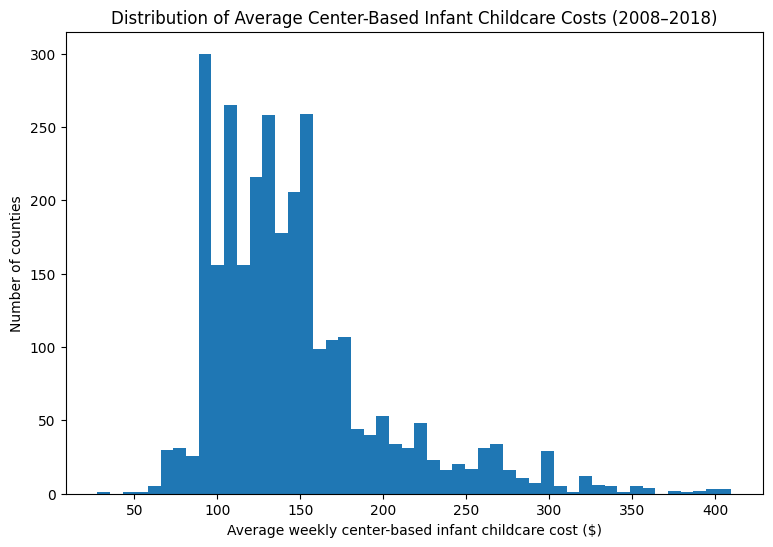

In [25]:
# Average each numeric variable across all years for each county
df_avg = (df.groupby("county_fips_code").mean(numeric_only=True).reset_index())
infant_prices_avg = df_avg["mc_infant"].dropna()
plt.figure(figsize=(9,6))
plt.hist(infant_prices_avg, bins=50)
plt.xlabel("Average weekly center-based infant childcare cost ($)")
plt.ylabel("Number of counties")
plt.title("Distribution of Average Center-Based Infant Childcare Costs (2008–2018)")

plt.show()


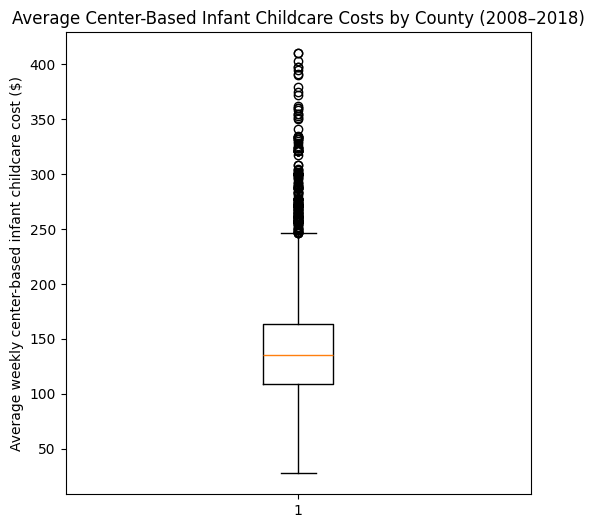

In [26]:
plt.figure(figsize=(6,6))
plt.boxplot(infant_prices_avg, vert=True, showfliers=True)
plt.ylabel("Average weekly center-based infant childcare cost ($)")
plt.title("Average Center-Based Infant Childcare Costs by County (2008–2018)")
plt.show()

The histogram and boxplot of county-level average center-based infant childcare costs (2008–2018) reveal substantial heterogeneity across U.S. counties. The distribution is strongly right-skewed, with most counties clustered between roughly $90 and $160 per week, and a long upper tail extending beyond $350–$400. This indicates that while many counties face moderate childcare costs, a relatively small subset experiences extremely high prices. The boxplot further highlights this pattern, showing a wide interquartile range and a large number of high-cost outliers, reinforcing the presence of structurally different childcare environments.

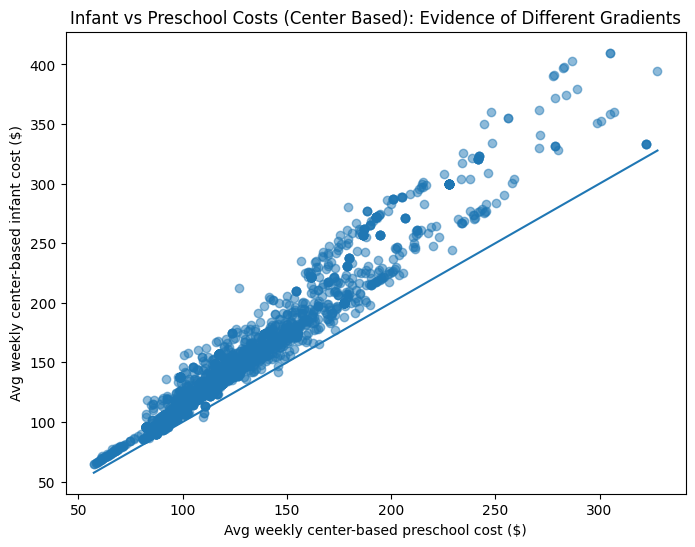

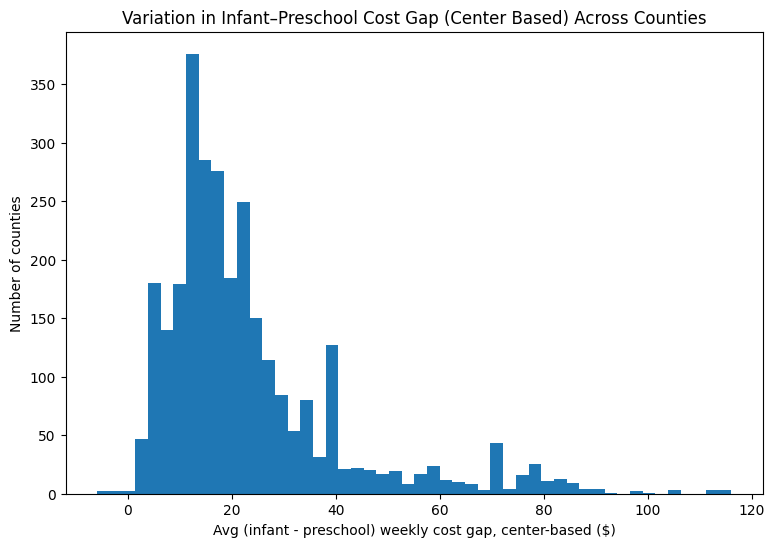

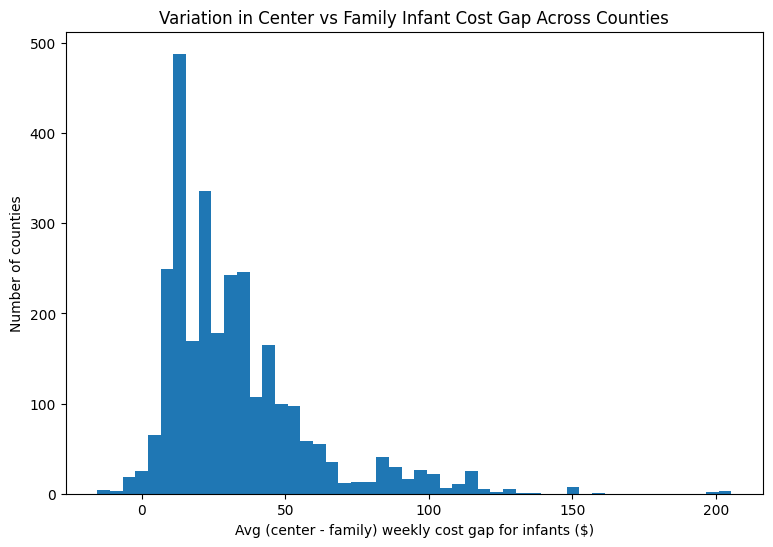

In [27]:
# 2) Build "gap" features to capture pricing structure (regimes)
#    - Age gradient within center-based care
#    - Age gradient within family childcare
#    - Center vs family gap for infant and preschool

df_gaps = df_avg.copy()

df_gaps["gap_center_infant_minus_preschool"] = df_gaps["mc_infant"] - df_gaps["mc_preschool"]
df_gaps["gap_family_infant_minus_preschool"] = df_gaps["mfcc_infant"] - df_gaps["mfcc_preschool"]

df_gaps["gap_infant_center_minus_family"] = df_gaps["mc_infant"] - df_gaps["mfcc_infant"]
df_gaps["gap_preschool_center_minus_family"] = df_gaps["mc_preschool"] - df_gaps["mfcc_preschool"]

# Drop rows missing any of the key fields for cleaner plots
key_cols = ["mc_infant","mc_preschool","mfcc_infant","mfcc_preschool","gap_center_infant_minus_preschool","gap_family_infant_minus_preschool", "gap_infant_center_minus_family","gap_preschool_center_minus_family"]
df_plot = df_gaps.dropna(subset=key_cols).copy()

# Plot A: Age gradient (Infant vs Preschool) — Center-based shows whether counties have steep vs flat gradients

plt.figure(figsize=(8,6))
plt.scatter(df_plot["mc_preschool"], df_plot["mc_infant"], alpha=0.5)
plt.plot([df_plot["mc_preschool"].min(), df_plot["mc_preschool"].max()],
         [df_plot["mc_preschool"].min(), df_plot["mc_preschool"].max()])
plt.xlabel("Avg weekly center-based preschool cost ($)")
plt.ylabel("Avg weekly center-based infant cost ($)")
plt.title("Infant vs Preschool Costs (Center Based): Evidence of Different Gradients")
plt.show()

# Plot B: Distribution of age gradient (Center based) directly visualizes how the infant-preschool gap varies across counties

plt.figure(figsize=(9,6))
plt.hist(df_plot["gap_center_infant_minus_preschool"], bins=50)
plt.xlabel("Avg (infant - preschool) weekly cost gap, center-based ($)")
plt.ylabel("Number of counties")
plt.title("Variation in Infant–Preschool Cost Gap (Center Based) Across Counties")
plt.show()

# Plot C: Center vs Family gap (Infant) shows if counties have large vs small provider type differences
plt.figure(figsize=(9,6))
plt.hist(df_plot["gap_infant_center_minus_family"], bins=50)
plt.xlabel("Avg (center - family) weekly cost gap for infants ($)")
plt.ylabel("Number of counties")
plt.title("Variation in Center vs Family Infant Cost Gap Across Counties")
plt.show()

Illustrates that differences between infant and preschool costs, as well as between center-based and family childcare, vary widely across counties. While some counties exhibit relatively flat pricing structures, others show steep age-based gradients and large provider-type gaps. The wide dispersion and heavy right tails of these gap distributions, together with the two-dimensional pricing regime map, indicate the presence of multiple distinct childcare pricing regimes rather than a single national pattern. These observations motivate our focus on uncovering latent county types based on childcare cost structures.

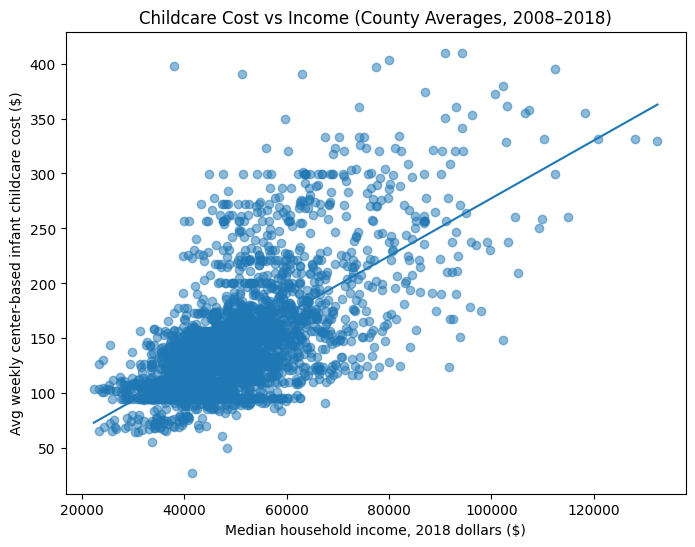

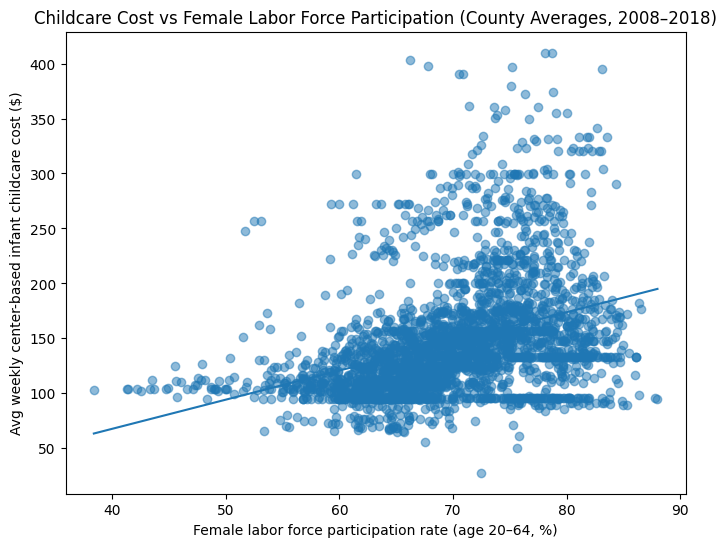

In [28]:
# county-level averages across years (one row per county)
df_avg = (df.groupby("county_fips_code").mean(numeric_only=True).reset_index())
plot_df = df_avg[["mc_infant", "mhi_2018", "flfpr_20to64"]].dropna().copy()
x_income = plot_df["mhi_2018"]
x_lfp    = plot_df["flfpr_20to64"]
y_cost   = plot_df["mc_infant"]

# helper to draw a simple best-fit line
def add_best_fit_line(x, y):
    m, b = np.polyfit(x, y, 1)
    xs = np.linspace(x.min(), x.max(), 200)
    plt.plot(xs, m*xs + b)


# plot A: Cost vs Income

plt.figure(figsize=(8,6))
plt.scatter(x_income, y_cost, alpha=0.5)
add_best_fit_line(x_income, y_cost)
plt.xlabel("Median household income, 2018 dollars ($)")
plt.ylabel("Avg weekly center-based infant childcare cost ($)")
plt.title("Childcare Cost vs Income (County Averages, 2008–2018)")
plt.show()


# Plot B: Cost vs Female Labor Force Participation

plt.figure(figsize=(8,6))
plt.scatter(x_lfp, y_cost, alpha=0.5)
add_best_fit_line(x_lfp, y_cost)
plt.xlabel("Female labor force participation rate (age 20–64, %)")
plt.ylabel("Avg weekly center-based infant childcare cost ($)")
plt.title("Childcare Cost vs Female Labor Force Participation (County Averages, 2008–2018)")
plt.show()

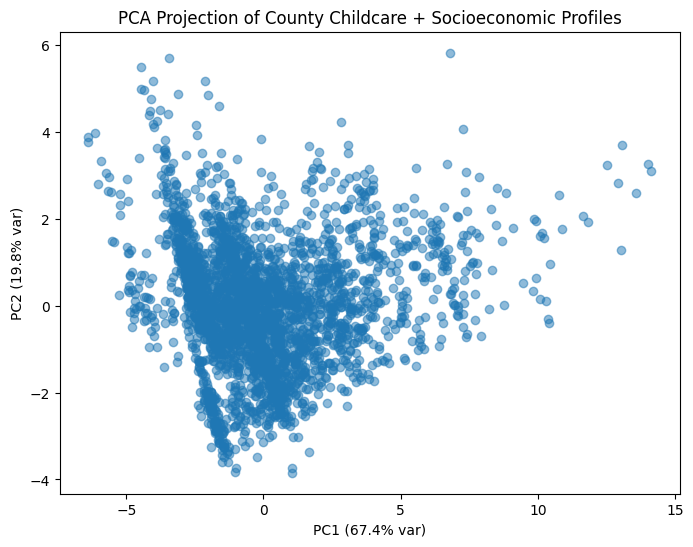

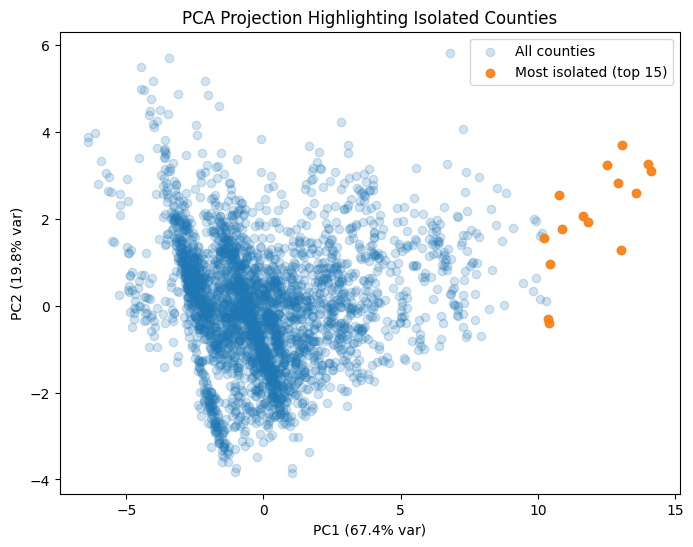

Most isolated counties (county_fips_code):
[ 8097 51610 51107 56039  6081  6075  6041 36079 36119 51013 36103 36087
 36059 25017 25021]

Most isolated counties (name):


,county_fips_code,county_name,state_name
0,8097,Pitkin County,Colorado
1,51610,Falls Church city,Virginia
2,51107,Loudoun County,Virginia
3,56039,Teton County,Wyoming
4,6081,San Mateo County,California
5,6075,San Francisco County,California
6,6041,Marin County,California
7,36079,Putnam County,New York
8,36119,Westchester County,New York
9,51013,Arlington County,Virginia


In [65]:
# County-level averages (one row per county)
df_avg = (
    df.groupby("county_fips_code")
      .mean(numeric_only=True)
      .reset_index()
)

# Select childcare cost + socioeconomic variables for a "county profile"
feature_cols = [
    # childcare costs (center + family, age groups)
    "mc_infant", "mc_toddler", "mc_preschool",
    "mfcc_infant", "mfcc_toddler", "mfcc_preschool",
    # socioeconomics
    "mhi_2018", "flfpr_20to64", "unr_20to64", "pr_p"
]

X = df_avg[feature_cols].copy()

# Impute missing values + standardize (important for PCA/UMAP)
imputer = SimpleImputer(strategy="median")
scaler = StandardScaler()

X_imputed = imputer.fit_transform(X)
X_scaled = scaler.fit_transform(X_imputed)


# Plot A: PCA projection (2D)
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], alpha=0.5)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
plt.title("PCA Projection of County Childcare + Socioeconomic Profiles")
plt.show()

# Identify "isolated" counties in PCA space (largest distance from center)
pca_dist = np.sqrt(X_pca[:,0]**2 + X_pca[:,1]**2)
top_idx = np.argsort(pca_dist)[-15:]  # top 15 most isolated

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], alpha=0.2, label="All counties")
plt.scatter(X_pca[top_idx,0], X_pca[top_idx,1], alpha=0.9, label="Most isolated (top 15)")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
plt.title("PCA Projection Highlighting Isolated Counties")
plt.legend()
plt.show()

# Show which counties are isolated (FIPS list; join names if you merged counties info earlier)
isolated_fips = df_avg.loc[top_idx, "county_fips_code"].values
print("Most isolated counties (county_fips_code):")
print(isolated_fips)
if {"county_name", "state_name"}.issubset(df.columns):
    fips_to_name = (
        df[["county_fips_code", "county_name", "state_name"]]
        .drop_duplicates()
        .set_index("county_fips_code")
    )
    print("\nMost isolated counties (name):")
    display(fips_to_name.loc[isolated_fips].reset_index())


# **2. EDA & Preprocessing Updates**

In [69]:
# 0) County-level dataset (one row per county)
df_avg = (df.groupby("county_fips_code").mean(numeric_only=True).reset_index())
X = df_avg[feature_cols].copy()

In [72]:
# 1) Missingness + summary stats (for Section 2 write-up)
missing_rate = X.isna().mean().sort_values(ascending=False)
print("Missing rate by feature:")
print(missing_rate)

summary_stats = X.describe().T[["mean", "std", "min", "max"]]
print("\nSummary stats (county averages):")
print(summary_stats)

Missing rate by feature:
mfcc_toddler      0.080471
mfcc_infant       0.080471
mfcc_preschool    0.080471
mc_infant         0.076336
mc_toddler        0.076336
mc_preschool      0.076336
mhi_2018          0.000000
flfpr_20to64      0.000000
unr_20to64        0.000000
pr_p              0.000000
dtype: float64

Summary stats (county averages):
                        mean           std           min            max
mc_infant         147.495269     53.290995     27.730000     409.881818
mc_toddler        132.758219     44.240447     21.540000     377.818182
mc_preschool      124.083381     38.939376     21.540000     327.800000
mfcc_infant       114.813778     32.712787     53.803333     299.432727
mfcc_toddler      108.535699     29.949447     48.062222     291.130000
mfcc_preschool    105.879820     28.748923     45.820000     281.260000
mhi_2018        50449.538443  13029.445529  22306.048182  132466.600000
flfpr_20to64       70.088699      7.244722     38.381818      96.518182
unr_20to

Missingness is limited to childcare price variables, with approximately 7–8 percent of county-level averages missing, while income, labor force participation, unemployment, and poverty measures are complete. Results indicate dispersion in childcare prices across counties, particularly for center-based infant care, where weekly averages range from under 30 to 400 dollars.

In [71]:
# 3) Impute missing values + standardize
# ------------------------------------------------------------
imputer = SimpleImputer(strategy="median")
X_imputed = imputer.fit_transform(X)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)


In [73]:
# 4) PCA (explain variance + interpret PCs)
pca = PCA(n_components=5, random_state=42)
X_pca = pca.fit_transform(X_scaled)

explained = pca.explained_variance_ratio_
print("\nExplained variance ratio (PC1..PC5):")
print(explained)
print("\nCumulative explained variance:")
print(np.cumsum(explained))

loadings = pd.DataFrame(
    pca.components_.T,
    index=feature_cols,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)]
)

print("\nLoadings for PC1 and PC2 (sorted by PC1):")
print(loadings[["PC1", "PC2"]].sort_values("PC1", ascending=False))


Explained variance ratio (PC1..PC5):
[0.6735454  0.19755211 0.0463138  0.0399374  0.01943103]

Cumulative explained variance:
[0.6735454  0.87109751 0.91741131 0.95734871 0.97677974]

Loadings for PC1 and PC2 (sorted by PC1):
                     PC1       PC2
mc_preschool    0.367235  0.146820
mfcc_preschool  0.366284  0.162814
mc_toddler      0.366055  0.142226
mfcc_toddler    0.365619  0.172581
mc_infant       0.363672  0.164539
mfcc_infant     0.363435  0.175460
mhi_2018        0.300984 -0.270251
flfpr_20to64    0.201939 -0.439709
unr_20to64     -0.114905  0.573703
pr_p           -0.233206  0.498547


After median imputation and standardization, principal component analysis (PCA)indicates that the first two components explain approximately 87 percent of total variation in county childcare and socioeconomic profiles. PCA shows that most cross-county variation is driven by a dominant cost dimension loading uniformly on childcare prices, with a secondary component capturing socioeconomic conditions independent of overall price level.

In [74]:
# 5) Identify "isolated" counties in PCA space (PC1-PC2 distance)
# ------------------------------------------------------------
pca_dist = np.sqrt(X_pca[:, 0]**2 + X_pca[:, 1]**2)

print("\nDistance percentiles in PCA space (PC1-PC2):")
print(pd.Series(np.percentile(pca_dist, [50, 75, 90, 95, 99]),
                index=["50%", "75%", "90%", "95%", "99%"]))

top_k = 15
top_idx = np.argsort(pca_dist)[-top_k:]

isolated = df_avg.loc[top_idx, ["county_fips_code"] + feature_cols].copy()
print(f"\nTop {top_k} most isolated counties (FIPS + features):")
print(isolated)


Distance percentiles in PCA space (PC1-PC2):
50%    2.118031
75%    2.988493
90%    4.334123
95%    5.734212
99%    8.500464
dtype: float64

Top 15 most isolated counties (FIPS + features):
      county_fips_code   mc_infant  mc_toddler  mc_preschool  mfcc_infant  \
294               8097  333.550000  306.550000    322.200000   225.000000   
2927             51610  331.600000  278.600000    278.600000   229.000000   
2873             51107  329.700000  271.100000    271.100000   229.000000   
3140             56039  290.776000  257.304000    254.176000   277.920000   
227               6081  371.895455  278.659091    278.659091   247.020000   
224               6075  374.293636  283.700000    283.700000   257.549091   
207               6041  379.463636  289.380909    289.380909   260.241818   
1868             36079  328.630000  305.160000    279.880000   267.290000   
1888             36119  350.690000  325.640000    298.670000   285.960000   
2827             51013  394.800000  327

Distance percentiles in the two-dimensional PCA space indicate that most counties cluster close to the center, while structural extremity is concentrated in a very small upper tail, with the top 5 percent of counties located more than 5.7 standardized units from the center. The most isolated counties are characterized by high childcare prices across all provider types and age groups, combined with relatively high income levels, which suggests that structural extremity arises from consistently elevated cost environments rather than from isolated price gaps or atypical gradients.

In [75]:
# Profile isolated counties vs overall counties
isolated_profile = isolated[feature_cols].describe().T[["mean", "min", "max"]]
overall_profile = df_avg[feature_cols].describe().T[["mean", "min", "max"]]

print("\nIsolated counties profile (mean/min/max):")
print(isolated_profile)

print("\nOverall counties profile (mean/min/max):")
print(overall_profile)


Isolated counties profile (mean/min/max):
                        mean           min            max
mc_infant         358.439491    290.776000     409.881818
mc_toddler        311.628691    257.304000     377.818182
mc_preschool      293.756521    254.176000     327.800000
mfcc_infant       268.658424    225.000000     299.432727
mfcc_toddler      254.137842    196.500000     291.130000
mfcc_preschool    248.060739    196.500000     281.260000
mhi_2018        99519.537212  74054.930000  132466.600000
flfpr_20to64       77.750303     73.563636      84.310909
unr_20to64          5.078485      2.641818       6.490909
pr_p                7.455394      3.330909      12.927273

Overall counties profile (mean/min/max):
                        mean           min            max
mc_infant         147.495269     27.730000     409.881818
mc_toddler        132.758219     21.540000     377.818182
mc_preschool      124.083381     21.540000     327.800000
mfcc_infant       114.813778     53.803333   

Isolated counties are characterized by high childcare prices across all care types and ages, with mean values more than double those observed nationally. Compared with the overall sample, these counties also exhibit higher income levels, and lower unemployment and poverty rates, indicating that extremity arises from consistent differences across multiple dimensions rather than from single outlier variables.

In [84]:
# 6) Construct pricing structure features (gradients + gaps)
# ------------------------------------------------------------
df_avg["infant_center_preschool_gap"] = df_avg["mc_infant"] - df_avg["mc_preschool"]
df_avg["infant_family_preschool_gap"] = df_avg["mfcc_infant"] - df_avg["mfcc_preschool"]
df_avg["infant_center_family_gap"] = df_avg["mc_infant"] - df_avg["mfcc_infant"]
df_avg["toddler_center_family_gap"] = df_avg["mc_toddler"] - df_avg["mfcc_toddler"]
df_avg["preschool_center_family_gap"] = df_avg["mc_preschool"] - df_avg["mfcc_preschool"]

print("\nPricing structure features summary:")
print(df_avg[["infant_preschool_gap","infant_family_preschool_gap", "infant_center_family_gap", "toddler_center_family_gap","preschool_center_family_gap"]].describe())


Pricing structure features summary:
       infant_preschool_gap  infant_family_preschool_gap  \
count           2904.000000                  2891.000000   
mean              23.411888                     8.933959   
std               17.883384                     7.448850   
min              -10.480000                   -52.644000   
25%               12.668409                     4.288000   
50%               17.712273                     7.500000   
75%               27.671000                    11.670727   
max              116.140000                    46.620000   

       infant_center_family_gap  toddler_center_family_gap  \
count               2885.000000                2885.000000   
mean                  32.897465                  24.478364   
std                   25.891113                  19.517027   
min                  -15.475139                 -27.833000   
25%                   14.619000                  10.709000   
50%                   26.052857                  1

Constructed pricing structure features show substantial cross-county dispersion, with infant–preschool center-based price gaps averaging about 23 dollars/week but ranging from negative values to over 116 dollars. Center–family price gaps are positive on average but also span large ranges, including negative values, confirming that differences in pricing structure form a continuum rather than discrete categories.